<a href="https://colab.research.google.com/github/revanthbethala/shoreline_extraction/blob/main/swin_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 121.6 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
"""
Swin-LSTM Shoreline Change Predictor
"""

import os
import glob
import json
import math
from collections import defaultdict
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine

import cv2
from skimage import filters

from shapely.geometry import LineString, Point
from shapely.ops import nearest_points

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

# ----------------------
# Config
# ----------------------
DATA_DIR = "/content/drive/MyDrive/shoreline_data_augmented"  # path containing year-wise subfolders
YEARS = None  # if None, discovered automatically by listing folders
PATCH_SIZE = 224  # crop size for Swin input
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8
EMBED_DIM = 1024  # depends on Swin model chosen
SWIN_MODEL = 'swin_base_patch4_window7_224'  # timm model name (adjust if memory constrained)
SEQ_LEN = 5  # number of historical years used to predict next-year displacement
PRED_HORIZON = 1  # predict how many years ahead (1 means next year)
LR = 1e-4
EPOCHS = 30
OUTPUT_DIR = 'swin_lstm_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------------
# Utilities: IO & NDWI
# ----------------------

def list_year_folders(data_dir: str) -> List[str]:
    folders = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))]
    # try to sort by year if folder names are years
    try:
        folders = sorted(folders, key=lambda x: int(os.path.basename(x)))
    except Exception:
        folders = sorted(folders)
    return folders


def read_multiband_tif(path: str) -> Tuple[np.ndarray, Affine, dict]:
    """Returns numpy array with shape (C, H, W), transform and meta"""
    with rasterio.open(path) as src:
        arr = src.read()  # (bands, H, W)
        transform = src.transform
        meta = src.meta
    return arr, transform, meta


def compute_ndwi(arr: np.ndarray, green_idx=2, nir_idx=4) -> np.ndarray:
    """Compute NDWI safely and handle out-of-range or corrupted values."""
    b = arr.astype('float32')

    # Fallbacks in case of index errors
    green = b[green_idx] if green_idx < b.shape[0] else b[1]
    nir = b[nir_idx] if nir_idx < b.shape[0] else b[-1]

    # Compute NDWI
    denom = (green + nir)
    denom[denom == 0] = 1e-6
    ndwi = (green - nir) / denom

    # Clean up invalid values
    ndwi[np.isnan(ndwi)] = 0
    ndwi[np.isinf(ndwi)] = 0

    # 🚨 Normalize and clip extreme values
    # This prevents NDWI from having ranges like -1000 to 1000
    ndwi = np.clip(ndwi, -1, 1)
    ndwi = (ndwi - ndwi.min()) / (ndwi.max() - ndwi.min() + 1e-6)

    return ndwi


def shoreline_mask_from_ndwi(ndwi: np.ndarray, method='otsu') -> np.ndarray:
    """Return binary water mask: 1=water, 0=land. Handles constant/invalid NDWI arrays."""
    ndwi = np.nan_to_num(ndwi, nan=0.0)

    # Handle flat or invalid NDWI arrays (prevents Otsu crash)
    if np.allclose(ndwi, ndwi[0, 0]) or np.isnan(ndwi).all():
        return np.zeros_like(ndwi, dtype=np.uint8)

    if method == 'otsu':
        try:
            thr = filters.threshold_otsu(ndwi)
        except Exception:
            thr = 0.0
    else:
        thr = 0.0

    mask = (ndwi > thr).astype(np.uint8)
    return mask


def mask_to_shoreline_contours(mask: np.ndarray) -> List[np.ndarray]:
    """Find contours on mask boundary (water vs land). Returns list of contours in pixel coordinates (row, col).
    Uses OpenCV findContours which requires 0/255 image.
    """
    img = (mask * 255).astype('uint8')
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # convert contours to Nx2 arrays
    out = []
    for c in contours:
        pts = c.squeeze(1)  # (N,2) with (x, y) as (col, row)
        if pts.ndim == 1:
            continue
        # convert to (row, col)
        pts_rc = np.stack([pts[:,1], pts[:,0]], axis=1)
        out.append(pts_rc)
    return out

# ----------------------
# Geometric helpers
# ----------------------

def pixel_to_xy(transform: Affine, row: float, col: float) -> Tuple[float, float]:
    """Convert pixel (row, col) to real-world coordinates (x, y) using rasterio transform."""
    x, y = rasterio.transform.xy(transform, row, col)
    return x, y


def contour_to_linestring(contour: np.ndarray, transform: Affine) -> LineString:
    coords = [pixel_to_xy(transform, float(r), float(c)) for r, c in contour]
    return LineString(coords)

# ----------------------
# Generate transects
# ----------------------

def generate_even_transects(ls: LineString, n_transects: int = 200, length: float = 500.0) -> List[LineString]:
    """Generate transects (perpendicular segments) along the provided shoreline LineString.
    length: total length of transect in meters (both sides), so half-length each side.
    Returns list of LineString segments.
    """
    transects = []
    total_len = ls.length
    if total_len == 0:
        return transects
    for i in range(n_transects):
        frac = (i + 0.5) / n_transects
        pt = ls.interpolate(frac * total_len)
        # compute tangent by sampling slightly ahead
        ahead = ls.interpolate(min(frac * total_len + 1.0, total_len))
        dx = ahead.x - pt.x
        dy = ahead.y - pt.y
        # tangent vector (dx, dy); normal is (-dy, dx)
        norm = math.hypot(dx, dy)
        if norm == 0:
            continue
        nx = -dy / norm
        ny = dx / norm
        half = length / 2.0
        p1 = Point(pt.x + nx * half, pt.y + ny * half)
        p2 = Point(pt.x - nx * half, pt.y - ny * half)
        transects.append(LineString([p1, p2]))
    return transects

# ----------------------
# Sampling shoreline distance along transect per year
# ----------------------

def intersect_transect_shoreline(transect: LineString, shoreline: LineString) -> List[Point]:
    inter = transect.intersection(shoreline)
    pts = []
    if inter.is_empty:
        return pts
    if isinstance(inter, Point):
        pts.append(inter)
    else:
        for g in inter.geoms:
            if isinstance(g, Point):
                pts.append(g)
    return pts

def project_point_distance_along_transect(transect: LineString, pt: Point) -> float:
    """Return signed distance from transect start point along transect to intersection point in meters.
    If point not on transect, finds nearest point on transect and returns its distance along.
    """
    ln = transect
    nearest = ln.interpolate(ln.project(pt))
    dist = ln.project(nearest)  # distance along transect from start
    # to make signed relative to mid point: we will return distance from center
    center = ln.interpolate(ln.length / 2.0)
    signed = dist - (ln.length / 2.0)
    return signed

# ----------------------
# Dataset assembly: build sequences per transect
# ----------------------

def build_shoreline_timeseries(data_dir: str, n_transects: int = 200, transect_length_m: float = 1000.0,
                               sample_patch_px: int = PATCH_SIZE) -> Tuple[List[dict], List[str]]:
    """Main pipeline to build time-series dataset.
    Returns list of records where each record corresponds to a (transect, year) sample holding:
    - embeddings (to be computed later) or image patch path
    - distance (signed meters) of shoreline intersection along transect
    - transect id, year
    """
    year_folders = list_year_folders(data_dir)
    year_names = [os.path.basename(x) for x in year_folders]
    print(f"Found year folders: {year_names}")

    # read first available image to extract baseline shoreline geometry
    sample_tif = glob.glob(os.path.join(year_folders[0], '*.tif'))[0]
    arr0, transform0, meta0 = read_multiband_tif(sample_tif)
    ndwi0 = compute_ndwi(arr0)
    mask0 = shoreline_mask_from_ndwi(ndwi0)
    contours0 = mask_to_shoreline_contours(mask0)
    # choose the largest contour
    contour0 = max(contours0, key=lambda c: c.shape[0])
    shoreline0 = contour_to_linestring(contour0, transform0)
    transects = generate_even_transects(shoreline0, n_transects, length=transect_length_m)
    print(f"Generated {len(transects)} transects.")

    # For each year, compute shoreline LineString (choose largest contour)
    year_shorelines = {}
    for yf, yname in zip(year_folders, year_names):
        tifs = glob.glob(os.path.join(yf, '*.tif'))
        if len(tifs) == 0:
            print(f"No tifs in {yf}; skipping")
            continue
        # pick first tif (should be same area)
        arr, transform, meta = read_multiband_tif(tifs[0])
        ndwi = compute_ndwi(arr)
        mask = shoreline_mask_from_ndwi(ndwi)
        contours = mask_to_shoreline_contours(mask)
        if len(contours) == 0:
            print(f"No contours in year {yname}")
            continue
        contour = max(contours, key=lambda c: c.shape[0])
        shoreline_ls = contour_to_linestring(contour, transform)
        year_shorelines[yname] = {
            'linestring': shoreline_ls,
            'transform': transform,
            'meta': meta,
            'tif_path': tifs[0]
        }

    records = []
    # For each transect and each year, compute intersection and sample patch
    for tidx, tran in enumerate(tqdm(transects, desc='Transects')):
        for yname in year_names:
            if yname not in year_shorelines:
                continue
            shore_ls = year_shorelines[yname]['linestring']
            hits = intersect_transect_shoreline(tran, shore_ls)
            if len(hits) == 0:
                # no intersection: mark as NaN
                distance = np.nan
                px_center = None
            else:
                # choose nearest to transect center
                center = tran.interpolate(tran.length / 2.0)
                # pick hit closest to center
                hits_sorted = sorted(hits, key=lambda p: p.distance(center))
                hit = hits_sorted[0]
                distance = project_point_distance_along_transect(tran, hit)
                px_center = (hit.x, hit.y)
            rec = {
                'transect_id': tidx,
                'year': yname,
                'distance_m': distance,
                'hit_xy': px_center,
                'tif_path': year_shorelines[yname]['tif_path'] if yname in year_shorelines else None,
                'transform': year_shorelines[yname]['transform'] if yname in year_shorelines else None
            }
            records.append(rec)

    df = pd.DataFrame(records)
    df_path = os.path.join(OUTPUT_DIR, 'shoreline_timeseries.csv')
    df.to_csv(df_path, index=False)
    print(f"Saved timeseries CSV to {df_path}")
    return df, year_names

# ----------------------
# Patch extraction and Embedding via Swin
# ----------------------
class SwinBackbone(nn.Module):
    def __init__(self, model_name=SWIN_MODEL, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        # num_classes=0 gives us feature vector
    def forward(self, x):
        return self.model(x)


def crop_patch_from_tif(tif_path: str, transform: Affine, xy: Tuple[float, float], patch_px=PATCH_SIZE) -> np.ndarray:
    """Crop a square patch centered at world coordinates xy (x,y) from the tif. Returns HWC uint8 patch scaled to 0-255.
    If xy is None, return None.
    """
    if xy is None:
        return None
    x, y = xy
    # convert xy to row, col
    col_f, row_f = ~transform * (x, y)
    row, col = int(round(row_f)), int(round(col_f))
    with rasterio.open(tif_path) as src:
        H, W = src.height, src.width
        half = patch_px // 2
        c0 = col - half
        r0 = row - half
        # clamp
        c0 = max(0, min(W - patch_px, c0))
        r0 = max(0, min(H - patch_px, r0))
        win = Window(c0, r0, patch_px, patch_px)
        arr = src.read(window=win)  # (bands, h, w)
    # convert to HWC
    arr = np.transpose(arr, (1,2,0))
    # if multi-band >3, pick first 3 or RGB ordering - user must verify
    if arr.shape[2] >= 3:
        patch = arr[:,:,:3]
    else:
        # replicate channels
        patch = np.repeat(arr[:,:,:1], 3, axis=2)
    # normalize to 0-255 for visual backbone - use linear scaling per patch
    pmin, pmax = np.nanmin(patch), np.nanmax(patch)
    if not np.isfinite(pmin) or not np.isfinite(pmax) or pmax == pmin:
        # Handle constant or invalid patch
        out = np.zeros_like(patch, dtype=np.uint8)
    else:
        patch = np.nan_to_num(patch, nan=0.0)
        out = np.clip(((patch - pmin) / (pmax - pmin + 1e-6) * 255.0), 0, 255).astype(np.uint8)
    return out


def compute_embeddings_for_dataframe(df: pd.DataFrame, batch_size:int = BATCH_SIZE, patch_size:int = PATCH_SIZE,
                                    model_name: str = SWIN_MODEL, device=DEVICE):
    backbone = SwinBackbone(model_name=model_name, pretrained=True).to(device)
    backbone.eval()
    preprocess = T.Compose([
        T.ToPILImage(),
        T.Resize((patch_size, patch_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    records = []
    patches = []
    meta = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc='Extract patches'):
        tif = row['tif_path']
        transform = row['transform']
        xy = row['hit_xy']
        patch = crop_patch_from_tif(tif, transform, xy, patch_px=patch_size)
        if patch is None:
            emb = None
        else:
            patches.append(preprocess(patch))
            meta.append((int(row['transect_id']), row['year'], idx))
        # process in batches
        if len(patches) >= batch_size:
            batch = torch.stack(patches).to(device)
            with torch.no_grad():
                feats = backbone(batch).cpu().numpy()  # (B, EMBED_DIM)
            for (tid, year, ridx), f in zip(meta, feats):
                records.append({'transect_id': tid, 'year': year, 'df_index': ridx, 'embedding': f})
            patches = []
            meta = []
    # final batch
    if len(patches) > 0:
        batch = torch.stack(patches).to(device)
        with torch.no_grad():
            feats = backbone(batch).cpu().numpy()
        for (tid, year, ridx), f in zip(meta, feats):
            records.append({'transect_id': tid, 'year': year, 'df_index': ridx, 'embedding': f})
    emb_df = pd.DataFrame(records)
    emb_path = os.path.join(OUTPUT_DIR, 'embeddings.npy')
    # save embeddings as dict keyed by (transect, year)
    emb_dict = {(int(r.transect_id), str(r.year)): r.embedding for r in emb_df.itertuples()}
    np.save(emb_path, emb_dict, allow_pickle=True)
    print(f"Saved embeddings to {emb_path}")
    return emb_dict

# ----------------------
# Prepare sequences dataset for LSTM
# ----------------------
class TransectSequenceDataset(Dataset):
    def __init__(self, emb_dict, df, year_order: List[str], seq_len=SEQ_LEN, pred_horizon=PRED_HORIZON):
        # emb_dict keyed by (transect_id, year) -> embedding
        self.emb = emb_dict
        self.df = df
        self.year_order = year_order
        self.seq_len = seq_len
        self.pred_horizon = pred_horizon
        self.transects = sorted(df['transect_id'].unique())
        self.samples = self._build_samples()

    def _build_samples(self):
        samples = []
        for tid in self.transects:
            # gather years where embedding exists for this transect
            available_years = [y for y in self.year_order if (tid, y) in self.emb]
            # convert to indices
            for i in range(len(available_years) - self.seq_len - self.pred_horizon + 1):
                seq_years = available_years[i:i+self.seq_len]
                target_year = available_years[i+self.seq_len + self.pred_horizon - 1]
                # get distances for target and last year
                # distance for last entry and target entry
                try:
                    last_idx = int(self.df[(self.df.transect_id==tid)&(self.df.year==seq_years[-1])].index[0])
                    targ_idx = int(self.df[(self.df.transect_id==tid)&(self.df.year==target_year)].index[0])
                except Exception:
                    continue
                last_dist = self.df.loc[last_idx, 'distance_m']
                targ_dist = self.df.loc[targ_idx, 'distance_m']
                if np.isnan(last_dist) or np.isnan(targ_dist):
                    continue
                # compute target delta (meters from last year to target year)
                delta = targ_dist - last_dist
                # collect embeddings
                seq_emb = [self.emb[(tid, y)] for y in seq_years]
                samples.append({'transect_id': tid, 'seq_years': seq_years, 'emb': np.stack(seq_emb), 'target': delta})
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        x = torch.from_numpy(s['emb']).float()  # (seq_len, emb_dim)
        y = torch.tensor([s['target']], dtype=torch.float32)
        return x, y

# ----------------------
# LSTM model
# ----------------------
class LSTMRegressor(nn.Module):
    def __init__(self, emb_dim=EMBED_DIM, hidden_dim=256, n_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        # x: (B, seq_len, emb_dim)
        out, (hn, cn) = self.lstm(x)
        # take last timestep
        last = out[:, -1, :]
        return self.head(last)

# ----------------------
# Training loop
# ----------------------

def train_model(train_loader, val_loader, emb_dim=EMBED_DIM, device=DEVICE):
    model = LSTMRegressor(emb_dim=emb_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    best_val = 1e12
    for epoch in range(1, EPOCHS+1):
        model.train()
        total_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred.squeeze(1), y.squeeze(1))
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * x.size(0)
        avg_train = total_loss / len(train_loader.dataset)

        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                pred = model(x)
                loss = loss_fn(pred.squeeze(1), y.squeeze(1))
                val_loss += loss.item() * x.size(0)
        avg_val = val_loss / len(val_loader.dataset)
        print(f"Epoch {epoch}/{EPOCHS}  train={avg_train:.4f}  val={avg_val:.4f}")
        if avg_val < best_val:
            best_val = avg_val
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_lstm.pth'))
    return model

# ----------------------
# Putting it all together
# ----------------------

def run_pipeline():
    # build timeseries CSV and df
    df, years = build_shoreline_timeseries(DATA_DIR, n_transects=200, transect_length_m=1000.0)
    # compute embeddings
    emb_dict = compute_embeddings_for_dataframe(df)
    # build dataset
    ds = TransectSequenceDataset(emb_dict, df, year_order=years, seq_len=SEQ_LEN)
    if len(ds) == 0:
        print("No training samples were created. Try adjusting SEQ_LEN, or ensure embeddings and distances are available for consecutive years.")
        return
    # split train/val
    n = len(ds)
    idxs = list(range(n))
    split = int(0.8 * n)
    train_idx = idxs[:split]
    val_idx = idxs[split:]
    from torch.utils.data import Subset
    train_loader = DataLoader(Subset(ds, train_idx), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(Subset(ds, val_idx), batch_size=BATCH_SIZE)
    # train
    model = train_model(train_loader, val_loader)
    print("Training complete. Model saved to 'best_lstm.pth'")

if __name__ == '__main__':
    run_pipeline()


Found year folders: ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
Generated 200 transects.


Transects: 100%|██████████| 200/200 [00:01<00:00, 123.97it/s]


Saved timeseries CSV to swin_lstm_output/shoreline_timeseries.csv


Extract patches: 100%|██████████| 7000/7000 [06:27<00:00, 18.07it/s]


Saved embeddings to swin_lstm_output/embeddings.npy
Epoch 1/30  train=6928.2998  val=1757.7351
Epoch 2/30  train=6928.0491  val=1757.5851
Epoch 3/30  train=6927.8900  val=1757.5085
Epoch 4/30  train=6927.0479  val=1753.2975
Epoch 5/30  train=6889.8696  val=1788.5916
Epoch 6/30  train=6716.5343  val=1938.6249
Epoch 7/30  train=6527.3005  val=1994.8419
Epoch 8/30  train=6329.1622  val=2203.0489
Epoch 9/30  train=6137.5108  val=2119.1826
Epoch 10/30  train=5924.3738  val=2215.0411
Epoch 11/30  train=5674.3850  val=2647.7961
Epoch 12/30  train=5431.3602  val=2620.5454
Epoch 13/30  train=5172.0571  val=2405.3931
Epoch 14/30  train=4926.9687  val=3304.8079
Epoch 15/30  train=4675.4951  val=3202.1910
Epoch 16/30  train=4354.1228  val=3174.6161
Epoch 17/30  train=4126.1365  val=3036.5042
Epoch 18/30  train=3867.9874  val=2985.9390
Epoch 19/30  train=3611.3002  val=3403.7000
Epoch 20/30  train=3328.2708  val=3319.2905
Epoch 21/30  train=3224.9023  val=2830.1667
Epoch 22/30  train=3105.2501  val

[INFO] Loaded embeddings shape: (6602, 1024)


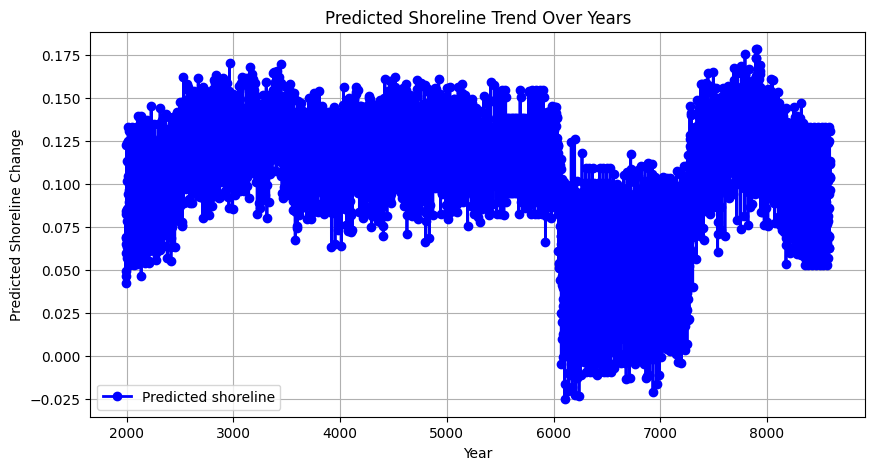


[RESULT] Average yearly change: 0.00001
[RESULT] 🌊 Shoreline moving seaward (accretion)


In [ ]:
# ===========================================================
# ✅ Predict Shoreline Trend by Year (Final Stable Version)
# ===========================================================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# -----------------------------------------------------------
# Define the LSTM model (same as training)
# -----------------------------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=512, hidden_size=256, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)  # (batch, seq_len, 1)
        return out.squeeze(-1)  # (batch, seq_len)


# -----------------------------------------------------------
# Safe embedding loader that handles dicts, objects, lists, etc.
# -----------------------------------------------------------
def load_embeddings_safe(path):
    arr = np.load(path, allow_pickle=True)

    # 1️⃣ Unwrap 0-D arrays
    if isinstance(arr, np.ndarray) and arr.ndim == 0:
        arr = arr.item()

    # 2️⃣ If it's a dict (e.g., {'1990': embedding, '1991': embedding, ...})
    if isinstance(arr, dict):
        try:
            sorted_items = sorted(arr.items(), key=lambda x: int(x[0]))
        except Exception:
            sorted_items = list(arr.items())

        arr = [np.array(v, dtype=np.float32).flatten() for _, v in sorted_items]
        return np.stack(arr)

    # 3️⃣ If it's a list/tuple of arrays
    if isinstance(arr, (list, tuple)):
        arr = [np.array(e, dtype=np.float32).flatten() for e in arr]
        return np.stack(arr)

    # 4️⃣ If it's an object array
    if isinstance(arr, np.ndarray) and arr.dtype == object:
        arr = [np.array(e, dtype=np.float32).flatten() for e in arr if e is not None]
        return np.stack(arr)

    # 5️⃣ Fallback — ensure float32
    arr = np.array(arr, dtype=np.float32)
    return arr


# -----------------------------------------------------------
# Main function to predict & visualize yearly trend
# -----------------------------------------------------------
def predict_shoreline_trend_by_year(embeddings_path, model_path, start_year=1990):
    # Load embeddings safely
    embeddings = load_embeddings_safe(embeddings_path)
    print(f"[INFO] Loaded embeddings shape: {embeddings.shape}")

    # Convert to tensor
    embeddings = torch.tensor(embeddings, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, feat_dim]

    # Load model
    model = LSTMModel(input_size=embeddings.shape[-1])
    model.load_state_dict(torch.load(model_path, map_location="cpu"), strict=False)
    model.eval()

    # Predict
    with torch.no_grad():
        outputs = model(embeddings).squeeze().numpy()

    # Handle scalar/single-output case
    if np.isscalar(outputs):
        outputs = np.array([outputs])

    # Handle case where model gives single value (not sequence)
    if outputs.ndim == 0:
        outputs = np.expand_dims(outputs, axis=0)

    # Generate years safely
    num_points = len(outputs) if hasattr(outputs, "__len__") else 1
    years = np.arange(start_year, start_year + num_points)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(years, outputs, marker='o', color='b', linewidth=2, label="Predicted shoreline")
    plt.title("Predicted Shoreline Trend Over Years")
    plt.xlabel("Year")
    plt.ylabel("Predicted Shoreline Change")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Trend direction summary
    if len(outputs) > 1:
        mean_change = np.mean(np.diff(outputs))
    else:
        mean_change = 0

    if mean_change > 0:
        direction = "🌊 Shoreline moving seaward (accretion)"
    elif mean_change < 0:
        direction = "🏖️ Shoreline retreating landward (erosion)"
    else:
        direction = "⚖️ Shoreline stable"

    print(f"\n[RESULT] Average yearly change: {mean_change:.5f}")
    print(f"[RESULT] {direction}")

    return years, outputs


# -----------------------------------------------------------
# Run it 🚀
# -----------------------------------------------------------
years, yearly_means = predict_shoreline_trend_by_year(
    embeddings_path="/content/swin_lstm_output/embeddings.npy",
    model_path="/content/swin_lstm_output/best_lstm.pth",
    start_year=1990
)


In [2]:
# Cell 1: Install and Setup
# !pip install rasterio numpy pandas shapely scikit-image opencv-python torch torchvision timm tqdm
from google.colab import drive
import os
import glob
import json
import math
from collections import defaultdict
from typing import List, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm

import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine

import cv2
from skimage import filters

from shapely.geometry import LineString, Point
from shapely.ops import nearest_points

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm

drive.mount("/content/drive")
DATA_DIR = "/content/drive/MyDrive/shoreline_data_augmented"
OUTPUT_DIR = "/content/swin_lstm_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATCH_SIZE = 224
BATCH_SIZE = 8
EMBED_DIM = 2048
SEQ_LEN = 5
PRED_HORIZON = 1
EPOCHS = 30


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Discover years (folders)
year_folders = [os.path.join(DATA_DIR, x) for x in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, x))]
try:
    year_folders = sorted(year_folders, key=lambda x: int(os.path.basename(x)))
except Exception:
    year_folders = sorted(year_folders)
year_names = [os.path.basename(x) for x in year_folders]
print(f"Found year folders: {year_names}")

# Baseline shoreline
sample_tif = glob.glob(os.path.join(year_folders[0], '*.tif'))[0]
with rasterio.open(sample_tif) as src:
    arr0 = src.read()
    transform0 = src.transform
    meta0 = src.meta

b = arr0.astype('float32')
green = b[2] if 2 < b.shape[0] else b[1]
nir = b[4] if 4 < b.shape[0] else b[-1]
denom = (green + nir)
denom[denom == 0] = 1e-6
ndwi0 = (green - nir) / denom
ndwi0[np.isnan(ndwi0)] = 0
ndwi0[np.isinf(ndwi0)] = 0
ndwi0 = np.clip(ndwi0, -1, 1)
ndwi0 = (ndwi0 - ndwi0.min()) / (ndwi0.max() - ndwi0.min() + 1e-6)
mask0 = (ndwi0 > filters.threshold_otsu(ndwi0)).astype(np.uint8)
img0 = (mask0 * 255).astype('uint8')
contours0, _ = cv2.findContours(img0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour0 = max([c.squeeze(1) for c in contours0 if c.squeeze(1).ndim==2], key=lambda c: c.shape[0])
pts_rc = np.stack([contour0[:,1], contour0[:,0]], axis=1)
coords0 = [rasterio.transform.xy(transform0, float(r), float(c)) for r, c in pts_rc]
shoreline0 = LineString(coords0)

# Generate transects
n_transects = 200
transect_length_m = 1000.0
transects = []
total_len = shoreline0.length
for i in range(n_transects):
    frac = (i + 0.5) / n_transects
    pt = shoreline0.interpolate(frac * total_len)
    ahead = shoreline0.interpolate(min(frac * total_len + 1.0, total_len))
    dx, dy = ahead.x - pt.x, ahead.y - pt.y
    norm = math.hypot(dx, dy)
    if norm == 0: continue
    nx, ny = -dy / norm, dx / norm
    half = transect_length_m / 2.0
    p1 = Point(pt.x + nx * half, pt.y + ny * half)
    p2 = Point(pt.x - nx * half, pt.y - ny * half)
    transects.append(LineString([p1, p2]))
print(f"Generated {len(transects)} transects.")

# Make year shorelines (dict year->LineString)
year_shorelines = {}
for yf, yname in zip(year_folders, year_names):
    tifs = glob.glob(os.path.join(yf, '*.tif'))
    if not tifs: continue
    with rasterio.open(tifs[0]) as src:
        arr, transform, meta = src.read(), src.transform, src.meta
    b = arr.astype('float32')
    green = b[2] if 2 < b.shape[0] else b[1]
    nir = b[4] if 4 < b.shape[0] else b[-1]
    denom = (green + nir)
    denom[denom == 0] = 1e-6
    ndwi = (green - nir) / denom
    ndwi[np.isnan(ndwi)] = 0
    ndwi[np.isinf(ndwi)] = 0
    ndwi = np.clip(ndwi, -1, 1)
    ndwi = (ndwi - ndwi.min()) / (ndwi.max() - ndwi.min() + 1e-6)
    mask = (ndwi > filters.threshold_otsu(ndwi)).astype(np.uint8)
    img = (mask * 255).astype('uint8')
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours: continue
    contour = max([c.squeeze(1) for c in contours if c.squeeze(1).ndim==2], key=lambda c: c.shape[0])
    pts_rc = np.stack([contour[:,1], contour[:,0]], axis=1)
    coords = [rasterio.transform.xy(transform, float(r), float(c)) for r, c in pts_rc]
    shoreline_ls = LineString(coords)
    year_shorelines[yname] = {'linestring': shoreline_ls, 'transform': transform, 'meta': meta, 'tif_path': tifs[0]}

# Record data
records = []
for tidx, tran in enumerate(tqdm(transects, desc='Transects')):
    for yname in year_names:
        if yname not in year_shorelines: continue
        shore_ls = year_shorelines[yname]['linestring']
        inter = tran.intersection(shore_ls)
        pts = []
        if inter.is_empty:
            distance, px_center = np.nan, None
        elif isinstance(inter, Point):
            pts.append(inter)
        else:
            for g in inter.geoms:
                if isinstance(g, Point): pts.append(g)
        if pts:
            center = tran.interpolate(tran.length / 2.0)
            hit = sorted(pts, key=lambda p: p.distance(center))[0]
            d = tran.project(hit)
            signed = d - (tran.length / 2.0)
            distance, px_center = signed, (hit.x, hit.y)
        rec = {
            'transect_id': tidx,
            'year': yname,
            'distance_m': distance,
            'hit_xy': px_center,
            'tif_path': year_shorelines[yname]['tif_path'],
            'transform': year_shorelines[yname]['transform']
        }
        records.append(rec)
df = pd.DataFrame(records)
df_path = os.path.join(OUTPUT_DIR, 'shoreline_timeseries.csv')
df.to_csv(df_path, index=False)
print(f"Saved timeseries CSV to {df_path}")


Found year folders: ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
Generated 200 transects.


Transects: 100%|██████████| 200/200 [00:01<00:00, 144.73it/s]


Saved timeseries CSV to /content/swin_lstm_output/shoreline_timeseries.csv


       transect_id         year   distance_m
count   7000.00000  7000.000000  6602.000000
mean      99.50000  2007.000000    -7.762003
std       57.73843    10.100226    73.555362
min        0.00000  1990.000000  -500.000000
25%       49.75000  1998.000000    -8.672873
50%       99.50000  2007.000000     0.000000
75%      149.25000  2016.000000     0.000000
max      199.00000  2024.000000   490.000000


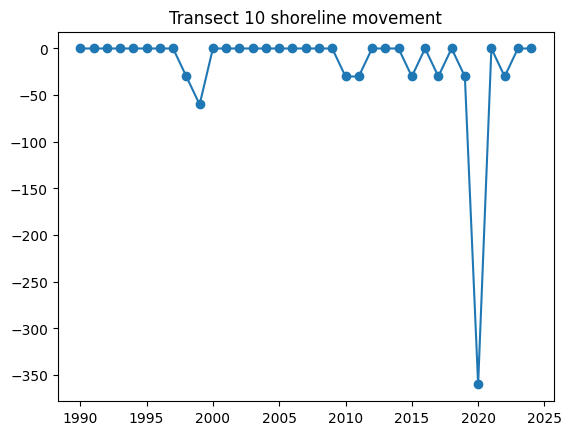

In [14]:
"""
=================================================
DEBUGGING
=================================================
"""
import pandas as pd
df = pd.read_csv("/content/swin_lstm_output/shoreline_timeseries.csv")
# print(df.head())
print(df.describe())
import matplotlib.pyplot as plt

transect_id = 10
sub = df[df['transect_id'] == transect_id]
plt.plot(sub['year'], sub['distance_m'], 'o-')
plt.title(f"Transect {transect_id} shoreline movement")
plt.show()



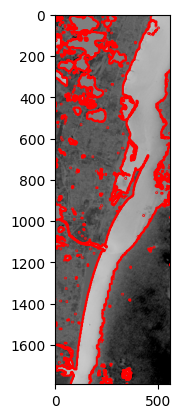

In [15]:
thresh = filters.threshold_otsu(ndwi)
plt.imshow(ndwi, cmap='gray')
plt.contour(ndwi > thresh, colors='red')

In [4]:
# cell 4
# Prepare Swin backbone/tools
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize((PATCH_SIZE, PATCH_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
CONV_MODEL = 'resnet50'  # or any other conv net you like from timm/torchvision
convnet = timm.create_model(CONV_MODEL, pretrained=True, num_classes=0, global_pool='avg').to(DEVICE)
convnet.eval()

records = []
patches = []
meta = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc='Extract patches'):
    tif = row['tif_path']
    transform = row['transform']
    xy = row['hit_xy']
    if xy is None:
        continue
    x, y = xy
    col_f, row_f = ~transform * (x, y)
    row0, col0 = int(round(row_f)), int(round(col_f))
    with rasterio.open(tif) as src:
        H, W = src.height, src.width
        half = PATCH_SIZE // 2
        c0 = max(0, min(W - PATCH_SIZE, col0 - half))
        r0 = max(0, min(H - PATCH_SIZE, row0 - half))
        win = Window(c0, r0, PATCH_SIZE, PATCH_SIZE)
        arr = src.read(window=win)
    arr = np.transpose(arr, (1,2,0))
    if arr.shape[2] >= 3:
        patch = arr[:,:,:3]
    else:
        patch = np.repeat(arr[:,:,:1], 3, axis=2)
    pmin, pmax = np.nanmin(patch), np.nanmax(patch)
    if not np.isfinite(pmin) or not np.isfinite(pmax) or pmax == pmin:
        out = np.zeros_like(patch, dtype=np.uint8)
    else:
        patch = np.nan_to_num(patch, nan=0.0)
        out = np.clip(((patch - pmin) / (pmax - pmin + 1e-6) * 255.0), 0, 255).astype(np.uint8)
    patch_tensor = preprocess(out)
    patches.append(patch_tensor)
    meta.append((int(row['transect_id']), row['year'], idx))
    # batch processing
    if len(patches) >= BATCH_SIZE:
        batch = torch.stack(patches).to(DEVICE)
        with torch.no_grad():
            feats = convnet(batch).cpu().numpy()
        for (tid, year, ridx), f in zip(meta, feats):
            records.append({'transect_id': tid, 'year': year, 'df_index': ridx, 'embedding': f})
        patches, meta = [], []
# final batch
if len(patches) > 0:
    batch = torch.stack(patches).to(DEVICE)
    with torch.no_grad():
        feats = convnet(batch).cpu().numpy()
    for (tid, year, ridx), f in zip(meta, feats):
        records.append({'transect_id': tid, 'year': year, 'df_index': ridx, 'embedding': f})

embeddings_df = pd.DataFrame(records)
emb_dict = {(int(r.transect_id), str(r.year)): r.embedding for r in embeddings_df.itertuples()}
emb_path = os.path.join(OUTPUT_DIR, 'embeddings.npy')
np.save(emb_path, emb_dict, allow_pickle=True)
print(f"Saved embeddings to {emb_path}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Extract patches: 100%|██████████| 7000/7000 [05:44<00:00, 20.31it/s]


Saved embeddings to /content/swin_lstm_output/embeddings.npy


In [5]:
# cell 5
year_names = sorted(df['year'].unique())
transects = sorted(df['transect_id'].unique())
samples = []

for tid in transects:
    available_years = [y for y in year_names if (tid, y) in emb_dict]
    for i in range(len(available_years) - SEQ_LEN - PRED_HORIZON + 1):
        seq_years = available_years[i:i+SEQ_LEN]
        target_year = available_years[i+SEQ_LEN + PRED_HORIZON - 1]
        last_idx = int(df[(df.transect_id==tid)&(df.year==seq_years[-1])].index[0])
        targ_idx = int(df[(df.transect_id==tid)&(df.year==target_year)].index[0])
        last_dist = df.loc[last_idx, 'distance_m']
        targ_dist = df.loc[targ_idx, 'distance_m']
        if np.isnan(last_dist) or np.isnan(targ_dist): continue
        delta = targ_dist - last_dist
        seq_emb = [emb_dict[(tid, y)] for y in seq_years]
        samples.append({'transect_id': tid, 'seq_years': seq_years, 'emb': np.stack(seq_emb), 'target': delta})

X = np.stack([s['emb'] for s in samples])
y = np.array([s['target'] for s in samples], dtype=np.float32)
print(f"LSTM training array shapes: X={X.shape}, y={y.shape}")


LSTM training array shapes: X=(5602, 5, 2048), y=(5602,)


In [6]:
# cell 6
from torch.utils.data import TensorDataset, DataLoader

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_val, y_val = X[train_split:], y[train_split:]
train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float().unsqueeze(1)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float().unsqueeze(1)), batch_size=BATCH_SIZE)

class LSTMRegressor(nn.Module):
    def __init__(self, emb_dim=EMBED_DIM, hidden_dim=256, n_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last)

model = LSTMRegressor(emb_dim=EMBED_DIM).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
best_val = 1e12

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    total_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        loss = loss_fn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()*x.size(0)
    avg_train = total_loss / len(train_loader.dataset)
    # val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_loss += loss.item()*x.size(0)
    avg_val = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch}/{EPOCHS}  train={avg_train:.4f}  val={avg_val:.4f}")
    if avg_val < best_val:
        best_val = avg_val
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_lstm.pth'))
print("Training complete. Model saved to 'best_lstm.pth'")


Epoch 1/30  train=6927.9637  val=1757.0042
Epoch 2/30  train=6927.9767  val=1757.0931
Epoch 3/30  train=6927.9202  val=1757.0656
Epoch 4/30  train=6927.8473  val=1756.9784
Epoch 5/30  train=6927.8641  val=1757.2782
Epoch 6/30  train=6923.9139  val=1769.2690
Epoch 7/30  train=6899.1530  val=1754.9714
Epoch 8/30  train=6771.8907  val=1776.3130
Epoch 9/30  train=6491.4756  val=1898.0938
Epoch 10/30  train=6223.4591  val=2137.9636
Epoch 11/30  train=5944.9298  val=2283.6370
Epoch 12/30  train=5640.1957  val=2484.9586
Epoch 13/30  train=5391.8228  val=2253.5412
Epoch 14/30  train=5106.9860  val=2294.7154
Epoch 15/30  train=4801.1242  val=2694.7266
Epoch 16/30  train=4575.1925  val=2917.1979
Epoch 17/30  train=4278.8241  val=2355.5095
Epoch 18/30  train=4095.9037  val=2544.3619
Epoch 19/30  train=3788.5566  val=3449.1768
Epoch 20/30  train=3554.0471  val=2737.8180
Epoch 21/30  train=3407.0212  val=2915.2542
Epoch 22/30  train=3170.7644  val=2258.2121
Epoch 23/30  train=2985.6290  val=2496.06

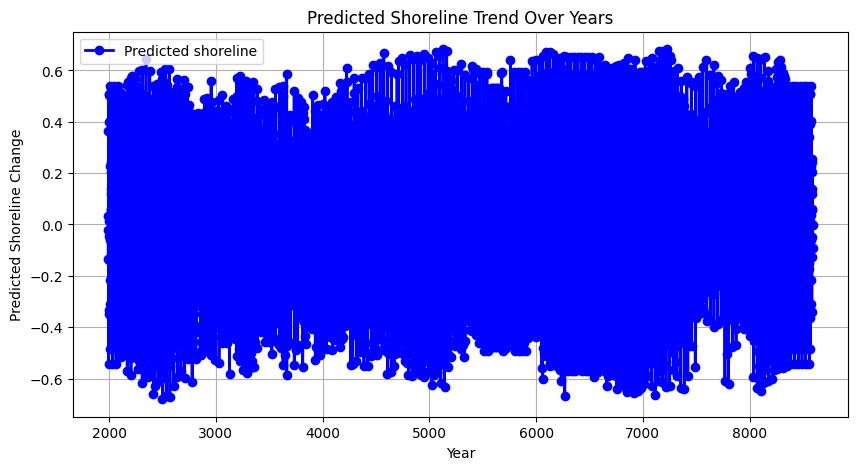


[RESULT] Average yearly change: 0.00001
[RESULT] 🌊 Shoreline moving seaward (accretion)


In [8]:
# Cell 7: Predict Shoreline Trend and Plot
import matplotlib.pyplot as plt

emb_arr = np.load(os.path.join(OUTPUT_DIR, 'embeddings.npy'), allow_pickle=True)
if isinstance(emb_arr, np.ndarray) and emb_arr.ndim == 0:
    emb_arr = emb_arr.item()
if isinstance(emb_arr, dict):
    try:
        sorted_items = sorted(emb_arr.items(), key=lambda x: int(x[0]))
    except Exception:
        sorted_items = list(emb_arr.items())
    emb_arr = [np.array(v, dtype=np.float32).flatten() for _, v in sorted_items]
    emb_arr = np.stack(emb_arr)
elif isinstance(emb_arr, (list, tuple)):
    emb_arr = [np.array(e, dtype=np.float32).flatten() for e in emb_arr]
    emb_arr = np.stack(emb_arr)
elif isinstance(emb_arr, np.ndarray) and emb_arr.dtype == object:
    emb_arr = [np.array(e, dtype=np.float32).flatten() for e in emb_arr if e is not None]
    emb_arr = np.stack(emb_arr)
else:
    emb_arr = np.array(emb_arr, dtype=np.float32)

class LSTMModel(nn.Module):
    def __init__(self, input_size=emb_arr.shape[-1], hidden_size=256, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out.squeeze(-1)

model_pred = LSTMModel(input_size=emb_arr.shape[-1])
model_pred.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_lstm.pth'), map_location="cpu"), strict=False)
model_pred.eval()
with torch.no_grad():
    pred_outputs = model_pred(torch.tensor(emb_arr).unsqueeze(0).float()).squeeze().numpy()
if np.isscalar(pred_outputs): pred_outputs = np.array([pred_outputs])
if pred_outputs.ndim == 0: pred_outputs = np.expand_dims(pred_outputs, axis=0)
years = np.arange(1990, 1990+len(pred_outputs))

plt.figure(figsize=(10, 5))
plt.plot(years, pred_outputs, marker='o', color='b', linewidth=2, label="Predicted shoreline")
plt.title("Predicted Shoreline Trend Over Years")
plt.xlabel("Year")
plt.ylabel("Predicted Shoreline Change")
plt.grid(True)
plt.legend()
plt.show()

mean_change = np.mean(np.diff(pred_outputs)) if len(pred_outputs) > 1 else 0
direction = ("🌊 Shoreline moving seaward (accretion)" if mean_change > 0
             else "🏖️ Shoreline retreating landward (erosion)" if mean_change < 0
             else "⚖️ Shoreline stable")
print(f"\n[RESULT] Average yearly change: {mean_change:.5f}")
print(f"[RESULT] {direction}")


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assume you already have your validation loader
all_true = []
all_pred = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        all_true.extend(y.cpu().numpy().flatten())
        all_pred.extend(pred.cpu().numpy().flatten())

# Convert to numpy arrays for metric computation
all_true = np.array(all_true)
all_pred = np.array(all_pred)

# Calculate metrics
mse = mean_squared_error(all_true, all_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_true, all_pred)
r2 = r2_score(all_true, all_pred)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R² (score): {r2:.4f}")


Validation MSE: 3162.5588
Validation RMSE: 56.2366
Validation MAE: 27.9313
Validation R² (score): -0.8090


🚀 Using device: cuda
✅ Loaded 33 valid shoreline sequences (single image per year)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/15: 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]


Epoch 1 | Train Loss: 0.588114 | Val Loss: 0.274955


Epoch 2/15: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch 2 | Train Loss: 0.276850 | Val Loss: 0.131476


Epoch 3/15: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s]


Epoch 3 | Train Loss: 0.108409 | Val Loss: 0.078240


Epoch 4/15: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]


Epoch 4 | Train Loss: 0.065043 | Val Loss: 0.056030


Epoch 5/15: 100%|██████████| 7/7 [00:01<00:00,  5.56it/s]


Epoch 5 | Train Loss: 0.049947 | Val Loss: 0.052653


Epoch 6/15: 100%|██████████| 7/7 [00:01<00:00,  5.45it/s]


Epoch 6 | Train Loss: 0.050546 | Val Loss: 0.052769


Epoch 7/15: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


Epoch 7 | Train Loss: 0.055574 | Val Loss: 0.052897


Epoch 8/15: 100%|██████████| 7/7 [00:01<00:00,  5.96it/s]


Epoch 8 | Train Loss: 0.044253 | Val Loss: 0.051701


Epoch 9/15: 100%|██████████| 7/7 [00:01<00:00,  5.89it/s]


Epoch 9 | Train Loss: 0.042535 | Val Loss: 0.046807


Epoch 10/15: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 10 | Train Loss: 0.044183 | Val Loss: 0.047169


Epoch 11/15: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch 11 | Train Loss: 0.041113 | Val Loss: 0.048581


Epoch 12/15: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


Epoch 12 | Train Loss: 0.049183 | Val Loss: 0.048623


Epoch 13/15: 100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


Epoch 13 | Train Loss: 0.038531 | Val Loss: 0.057553


Epoch 14/15: 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


Epoch 14 | Train Loss: 0.038720 | Val Loss: 0.053691


Epoch 15/15: 100%|██████████| 7/7 [00:01<00:00,  5.43it/s]


Epoch 15 | Train Loss: 0.040446 | Val Loss: 0.046676


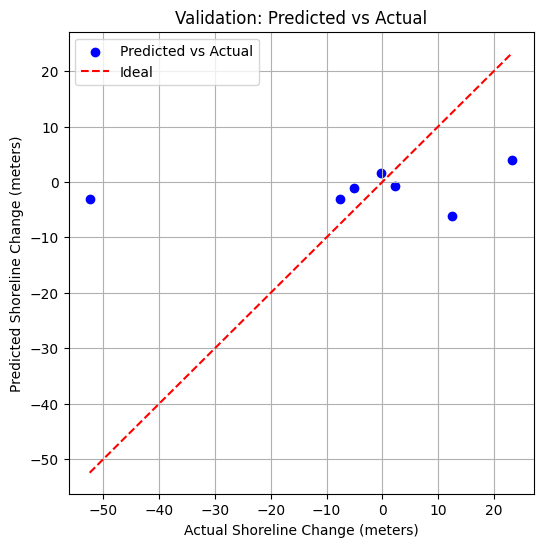


💾 Model saved: outputs/swin_transect_lstm.pth


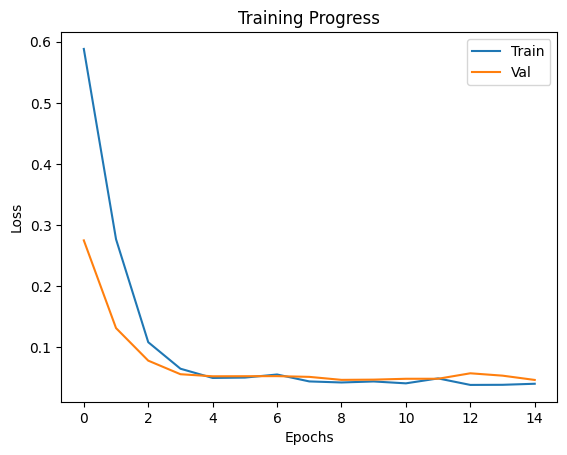

In [ ]:
# prev code
# ===============================================================
# Swin Transformer + Transect-based LSTM Shoreline Predictor
# Fully fixed version for multi-band Landsat/Sentinel images
# ===============================================================

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
from glob import glob
import rasterio
from skimage.transform import resize
from shapely.geometry import LineString
from skimage import measure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import product
# ===============================================================
# Transect extraction
# ===============================================================
def extract_transects_from_image(image_array, num_transects=10):
    """Convert multi-band image to transect distances using NDWI."""
    green, nir = image_array[1], image_array[3]  # adjust for your bands
    ndwi = np.clip((green - nir) / (green + nir + 1e-6), -1, 1)
    mask = ndwi > 0  # water = True

    contours = measure.find_contours(mask.astype(float), 0.5)
    if not contours:
        return np.zeros((num_transects,), dtype=np.float32), None

    largest = max(contours, key=lambda x: len(x))
    shoreline = LineString(largest)

    transect_positions = np.linspace(0, 1, num_transects)
    transect_distances = []
    for t in transect_positions:
        point = shoreline.interpolate(t, normalized=True)
        transect_distances.append(point.y)

    return np.array(transect_distances, dtype=np.float32), shoreline

# ===============================================================
# Dataset preparation
# ===============================================================
class TransectShorelineDataset(Dataset):
    def __init__(self, sequences, target_scaler=None, augment=False):
        self.sequences = sequences
        self.target_scaler = target_scaler
        self.augment = augment

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = self.sequences[idx]
        patches = torch.tensor(item["patches"], dtype=torch.float32)      # [T, C, H, W]
        transects = torch.tensor(item["transects"], dtype=torch.float32)  # [T, num_transects]
        target = item["target_distance"]

        if self.target_scaler:
            target = self.target_scaler.transform(np.array([[target]]))[0, 0]

        if self.augment:
            # Random horizontal flip and noise
            if np.random.rand() > 0.5:
                patches = torch.flip(patches, dims=[3])
            patches += torch.randn_like(patches) * 0.01

        return patches, transects, torch.tensor(target, dtype=torch.float32)

# ===============================================================
# Swin Transformer Feature Extractor
# ===============================================================
class SwinFeatureExtractor(nn.Module):
    def __init__(self, model_name="swin_tiny_patch4_window7_224", out_dim=128, in_channels=5):
        super().__init__()
        self.encoder = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=in_channels)
        self.fc = nn.Linear(self.encoder.num_features, out_dim)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        feats = self.encoder(x)
        feats = self.fc(feats)
        feats = feats.view(B, T, -1)
        return feats

# ===============================================================
# CNN-LSTM (Swin + Transect)
# ===============================================================
class SwinTransectLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=1, num_transects=10, in_channels=5):
        super().__init__()
        self.swin = SwinFeatureExtractor(out_dim=hidden_dim, in_channels=in_channels)
        self.transect_fc = nn.Linear(num_transects, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, images, transects):
        swin_feats = self.swin(images)                   # [B, T, hidden_dim]
        tran_feats = self.transect_fc(transects)         # [B, T, hidden_dim]
        combined = torch.cat([swin_feats, tran_feats], dim=-1)  # [B, T, 2*hidden_dim]
        lstm_out, _ = self.lstm(combined)
        last_out = lstm_out[:, -1, :]
        pred = self.fc_out(last_out).squeeze(-1)
        return pred

# ===============================================================
# Robust sequence loader
# ===============================================================
def load_shoreline_sequences(base_dir, num_transects=10, resize_shape=(224,224)):
    sequences = []
    years = sorted([y for y in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, y)) and y.isdigit()])

    for i in range(len(years) - 2):
        seq_years = years[i:i+3]
        patches_seq, transects_seq = [], []
        skip_sequence = False

        for y in seq_years:
            img_files = glob(os.path.join(base_dir, y, "*.tif"))
            if not img_files:
                skip_sequence = True
                break

            img_path = img_files[0]  # ✅ Take only the first image per year

            with rasterio.open(img_path) as src:
                img = src.read().astype(np.float32)[:5]  # first 5 bands
                img_norm = []

                for b in img:
                    b = np.nan_to_num(b, nan=0.0, posinf=0.0, neginf=0.0)
                    b = np.clip(b, -0.2, 1.6)
                    if np.max(b) - np.min(b) < 1e-6:
                        b = np.zeros_like(b)
                    else:
                        b = (b - b.min()) / (b.max() - b.min() + 1e-8)
                    b_resized = resize(b, resize_shape, mode='reflect', anti_aliasing=True)
                    b_resized = np.nan_to_num(b_resized, nan=0.0)
                    img_norm.append(b_resized)

                img_norm = np.stack(img_norm, axis=0)
                tvals, _ = extract_transects_from_image(img, num_transects)
                patches_seq.append(img_norm)
                transects_seq.append(tvals)

        if skip_sequence:
            continue

        patches_seq = np.nan_to_num(np.stack(patches_seq, axis=0), nan=0.0)
        transects_seq = np.nan_to_num(np.stack(transects_seq, axis=0), nan=0.0)
        target_distance = np.nan_to_num(transects_seq[-1].mean() - transects_seq[0].mean(), nan=0.0)

        sequences.append({
            "patches": patches_seq,
            "transects": transects_seq,
            "target_distance": target_distance
        })

    print(f"✅ Loaded {len(sequences)} valid shoreline sequences")
    return sequences
# ===============================
# Visualize predictions vs actual
# ===============================
def visualize_predictions(model, val_loader, target_scaler, device="cuda"):
    model.eval()
    preds_list, targets_list = [], []

    with torch.no_grad():
        for patches, transects, targets in val_loader:
            patches, transects = patches.to(device), transects.to(device)
            preds = model(patches, transects).cpu().numpy()
            targets = targets.numpy()
            preds_list.append(preds)
            targets_list.append(targets)

    preds = np.concatenate(preds_list)
    targets = np.concatenate(targets_list)

    # Inverse scale back to original range
    preds = target_scaler.inverse_transform(preds.reshape(-1,1)).flatten()
    targets = target_scaler.inverse_transform(targets.reshape(-1,1)).flatten()

    plt.figure(figsize=(6,6))
    plt.scatter(targets, preds, color='blue', label='Predicted vs Actual')
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--', label='Ideal')
    plt.xlabel("Actual Shoreline Change (meters)")
    plt.ylabel("Predicted Shoreline Change (meters)")
    plt.title("Validation: Predicted vs Actual")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===============================================================
# Training loop
# ===============================================================
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, device="cuda"):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for patches, transects, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            patches, transects, targets = patches.to(device), transects.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = model(patches, transects)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for patches, transects, targets in val_loader:
                patches, transects, targets = patches.to(device), transects.to(device), targets.to(device)
                preds = model(patches, transects)
                val_loss += criterion(preds, targets).item()

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")

    return model, train_losses, val_losses

# ===============================================================
# Main
# ===============================================================
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Using device: {device}")

    base_dir = "/content/drive/MyDrive/shoreline_data_augmented"  # Your path here
    sequences = load_shoreline_sequences(base_dir, num_transects=10)
    if len(sequences) == 0:
        print("❌ No sequences found. Check your data path!")
        return

    targets = np.array([seq["target_distance"] for seq in sequences]).reshape(-1,1)
    target_scaler = MinMaxScaler().fit(targets)

    train_seq, val_seq = train_test_split(sequences, test_size=0.2, random_state=42)
    train_loader = DataLoader(TransectShorelineDataset(train_seq, target_scaler, augment=True), batch_size=4, shuffle=True)
    val_loader = DataLoader(TransectShorelineDataset(val_seq, target_scaler, augment=False), batch_size=4, shuffle=False)

    model = SwinTransectLSTM(hidden_dim=128, num_layers=1, num_transects=10, in_channels=5).to(device)

    model, train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=15, lr=1e-4, device=device)
    visualize_predictions(model, val_loader, target_scaler, device=device)

    os.makedirs("outputs", exist_ok=True)
    torch.save(model.state_dict(), "outputs/swin_transect_lstm.pth")
    print("\n💾 Model saved: outputs/swin_transect_lstm.pth")


    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training Progress")
    plt.show()

if __name__ == "__main__":
    main()
